In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pingouin import kruskal
import scikit_posthocs as sp
import os
from statannot import add_stat_annotation
import numpy as np

In [2]:
# parser = argparse.ArgumentParser(description='GC_content_plots')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('GC_content_tsv', type=str, help='Input location of promoters GC_content tsv file')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '', nargs="?")
# parser.add_argument('variable1_name', type=str, help='Optional replacement name for 1st variable eg. non-specific',default = 'constitutive', nargs="?")
# parser.add_argument('variable2_name', type=str, help='Optional replacement name for 2nd variable eg. tissue&condition_specific',default = 'variable', nargs="?")
# parser.add_argument('author_name', type=str, help='Optional replacement name for author in reference to the geneset',default = 'Czechowski', nargs="?")
# parser.add_argument('palette', type=str, help='Optional replacement colour palette for plots',default = None, nargs="?")
# args = parser.parse_args()
# dependent_variable = 'GC_content'

In [41]:
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
tf_gene_categories = f'../../data/output/{file_names}/genes/tfs_czechowski_constitutive_variable_random_100.txt'
all_genes_ranked = f'../../data/output/{file_names}/genes/filtered80/AtGE_dev_gcRMA__all_probes__CV.tsv'
promoter_TF = f'../../data/output/{file_names}/TFBS_TF_class/promoters_5UTR_TF_CV/promoter_TF_CV.txt'
variable1_name = 'constitutive'
variable2_name = 'variable'

palette = 'deep'
#dependent_variable = 'tau'
dependent_variable = 'expression_CV'

output_folder_name = 'TF_target/'

In [6]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TF_target/  created


In [7]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TF_target/plots  created


In [32]:
def read_files(tf_gene_categories,promoter_TF):
    """read in the files as dfs"""    
    #all_gene_categories_dfs = pd.read_table(all_gene_categories, sep='\t',header=0)
    promoter_TF_df = pd.read_table(promoter_TF,sep='\t',header=0)
    tf_gene_categories_df = pd.read_table(tf_gene_categories, sep='\t',header=None)
    cols = ['TF_AGI','gene_type']
    tf_gene_categories_df.columns = cols
    #merge the dfs
    merged = pd.merge(tf_gene_categories_df, promoter_TF_df, on = 'TF_AGI', how='left')
    #remove NaN
    merged_filtered = merged[merged.TF_AGI_allgenes.notna()]
    
    

    return tf_gene_categories_df,promoter_TF_df,merged_filtered

In [9]:
def rep_sample(df, col, n, random_state):
    """function to return a df with equal sample sizes
    taken from here: https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe"""
    #identify number of categories
    nu = df[col].nunique()
    # find number of rows
    m = len(df)
    # integar divide total sample size by number of categories
    mpb = n // nu
    # multiply this by the number of categories and subtract from the number of samples to find the remainder
    mku = n - mpb * nu
    # make an array fileld with zeros corresponding to each category
    fills = np.zeros(nu)

    # make values in the array 1s up until the remainder
    fills[:mku] = 1

    # calculate sample sizes for each category
    sample_sizes = (np.ones(nu) * mpb + fills).astype(int)

    #group the df by categories
    gb = df.groupby(col)
    #define sample size function
    sample = lambda sub_df, i: sub_df.sample(sample_sizes[i], random_state = random_state)
    #run sample size function on each category
    subs = [sample(sub_df, i) for i, (_, sub_df) in enumerate(gb)]
    #return concatenated sub dfs
    return pd.concat(subs)  

In [11]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [77]:
def calculate_mean_CV(df):
    """calculate the mean coefficient of variation of the promoters the TF binds to"""
    #group by TF and calculate mean for each TF
    means = df.groupby('TF_AGI')['expression_CV'].mean()
    #turn into a dataframe
    means_df = pd.DataFrame(means)
    #turn the index into a new column
    means_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['TF_AGI', 'mean_cv']
    means_df.columns = cols
    
        
    #group by promoter and calculate SD (standard deviation) for each promoter
    #sd = df.groupby('promoter_AGI')['expression_CV'].std()
    #turn into a dataframe
    #sd_df = pd.DataFrame(sd)
    #turn the index into a new column
    #sd_df.reset_index(level=0, inplace=True)
    #name columns
    #cols = ['promoter_AGI', 'sd']
    #sd_df.columns = cols
    
    #merge the dfs
    #merged = pd.merge(means_df,sd_df)
    return means_df

In [134]:
def merge_genetype(df, gene_categories):
    """merge df with gene_categories file adding the genetype of the promoters (if in top 100 constitutive or top 100 variable promoters)"""
    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['TF_AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,df, on='TF_AGI', how='left')
    #drop NaN
    merged_filtered = merged.dropna()
    #reset index
    merged_filtered_index = merged_filtered.reset_index(drop=True)
    
    return merged_filtered_index

In [69]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind,palette,mean=False):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=[variable1_name, variable2_name, "control"]
    
    #set colour palette
    colours = sns.color_palette(palette)
    
   #make copy of df
    if mean == False:
        merged2 = df.copy()
   
        merged2_unique = merged2.drop_duplicates(['promoter_AGI'],keep='last')
    elif mean == True:
        merged2_unique = df.copy()
    #make sample sizes equal for comparison
    # identify sample size of the minimum category
    minimum_sample_size = merged2_unique.gene_type.value_counts().min()
    # print this
    print(f'sample size in each category = {minimum_sample_size}')
    #save sample size as file
    with open(f'../../data/output/{file_names}/{output_folder_name}plots/number_of_genes_in_each_category_{dependent_variable}.txt','w') as file:
        file.write('number_of_genes_in_each_category='+str(minimum_sample_size))
    
    
    # multiply this by the number of categories
    total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
    #select equal sample sizes of each category with a random state of 1 so it's reproducible
    equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
    # now filter out genes which were not selected using the minimum sample size
    to_remove = merged2_unique[~merged2_unique.TF_AGI.isin(equal_samplesizes.TF_AGI)]
    df = df[~df.TF_AGI.isin(to_remove.TF_AGI)]
    
    #if violin plot don't extend past datapoints
    if plot_kind == 'violin': 
        plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order,palette=colours, cut=0)
    else:
        plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order,palette=colours)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    box_pairs=[(variable1_name, variable2_name),(variable1_name, "control"),(variable2_name, "control")]
    #make empty list of p_values
    p_values = []
    #populate the list of p_values according to the box_pairs
    for pair in box_pairs:
        print(pair)
        #select p value for each pair
        p = stat.loc[pair[0],pair[1]]
        p_values.append(p)


    
    #add stats annotation to the plot
    test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                      box_pairs=box_pairs,
                                      text_format='star',
                                      loc='outside',verbose=2,
                                      perform_stat_test=False,
                                       pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()  
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')      

In [35]:
tf_gene_categories_dfs,promoter_TF_df,merged = read_files(tf_gene_categories,promoter_TF)

sample size in each category = 12


KeyboardInterrupt: 

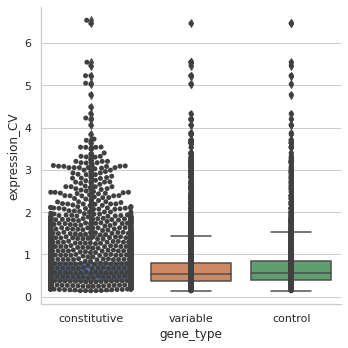

In [61]:
#plot the CV for each promoter gene_type - whole promoter individual TF CVs
make_plot(merged,'gene_type', 'expression_CV','Gene type', 'Promoter target expression CV', 'Czechowski_CV', 'box',palette)

In [109]:
#calculate mean CV of targets per TF
Czechowski_means = calculate_mean_CV(merged)

In [136]:
#add TF gene_type categories
Czechowski_means_genetype = merge_genetype(Czechowski_means, tf_gene_categories)

sample size in each category = 12
('constitutive', 'variable')
('constitutive', 'control')
('variable', 'control')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

constitutive v.s. variable: Custom statistical test, P_val:1.000e+00
variable v.s. control: Custom statistical test, P_val:8.864e-01
constitutive v.s. control: Custom statistical test, P_val:5.438e-01


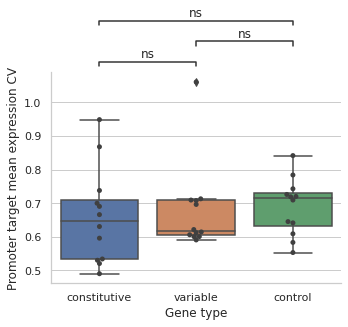

In [138]:
#plot the mean CV for each promoter gene_type - whole promoter mean TF CVs
make_plot(Czechowski_means_genetype,'gene_type', 'mean_cv','Gene type', 'Promoter target mean expression CV', 'Czechowski_CV_mean', 'box',palette,mean=True)

In [71]:
Czechowski_means_genetype

,TF_AGI,mean_cv
0,AT1G06180,0.841437
1,AT1G10120,0.645293
2,AT1G13450,0.553273
3,AT1G21910,0.614593
4,AT1G29160,0.696197
5,AT1G32150,0.737736
6,AT1G51700,0.709338
7,AT1G53170,0.609043
8,AT1G53910,0.583396
9,AT1G69010,0.596016
